In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore') #忽略警告


In [3]:
train = pd.read_csv('./data/titanic/train.csv',dtype={"Age": np.float64}) #dtype是指定欄位資料的型態 此邊是Age欄的資料型態是float64
test = pd.read_csv('./data/titanic/test.csv',dtype={"Age": np.float64})
submit = pd.read_csv('./data/titanic/gender_submission.csv')
PassengerId=test['PassengerId'] #把測試集的乘客ID記錄下來

In [4]:
#接下來合併train,test data 以利資料觀察、清洗
data=train.append(test) #合併

data.reset_index(inplace=True,drop=True)
#############################################################################
## 不reset的話原本的train,test的index合併後不會重新排序                       #
## https://www.twblogs.net/a/5c21eb8abd9eee16b3dae800                       #   
## drop=True: 把原來的索引index列去掉，丟掉。                                 #  
## drop=False:保留原來的索引（以前的可能是亂的)                                #     
## 修改一個對象時：                                                          #
##      inplace=True：不創建新的對象，直接對原始對象進行修改；                  #
##      inplace=False：對數據進行修改，創建並返回新的對象承載其修改結果。        #
############################################################################  
data.info()
data.describe()
data.head()

#由資料的資訊可知總量1309筆，其中Age,Cabin,Embarked,Survived有遺漏值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


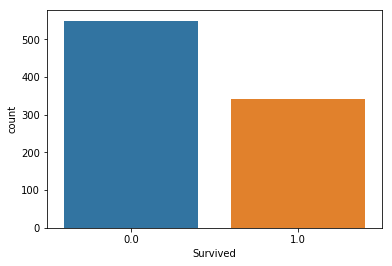

In [4]:
#觀察數據
#存活數量
sns.countplot(data['Survived'])

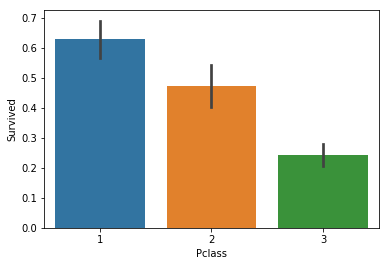

In [5]:
#艙等和存活率
sns.barplot(y=data['Survived'],x=data['Pclass'])

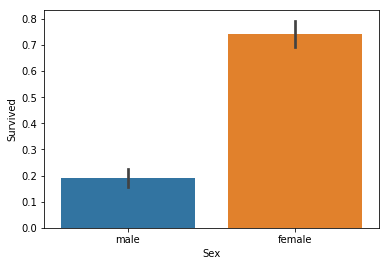

In [6]:
#性別和存活率
sns.barplot(y=data['Survived'],x=data['Sex'])

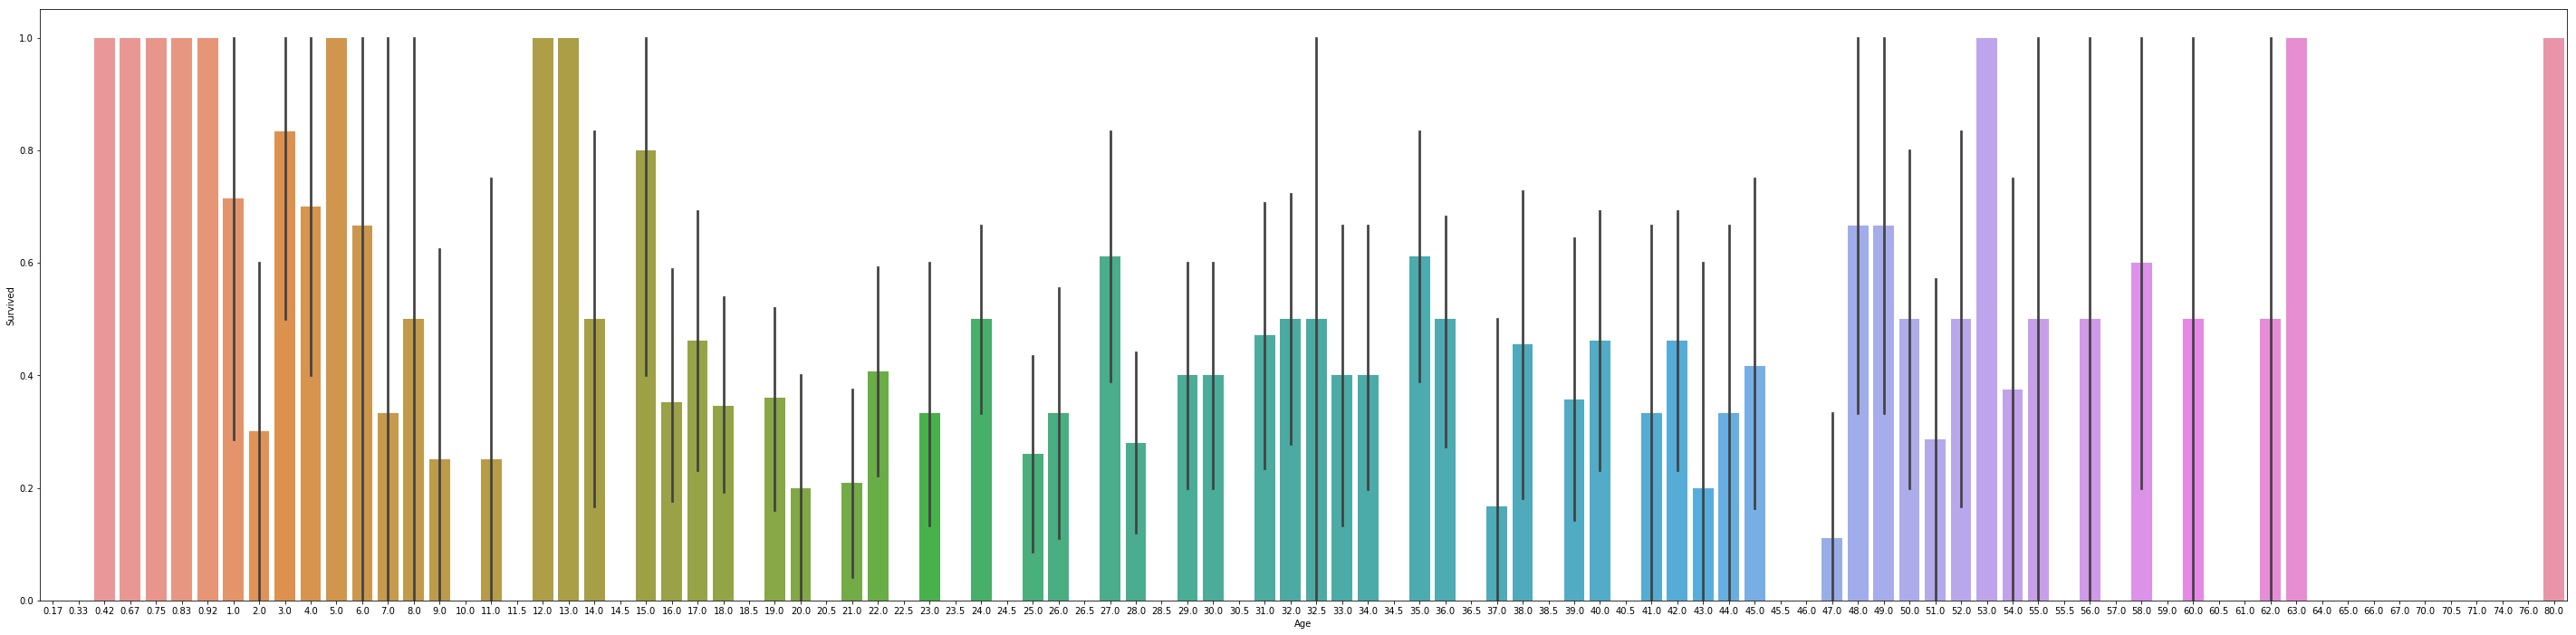

In [7]:
#年齡和存活率 (也許將年齡整理一下可以提高預測)
plt.figure(figsize=(50,12))
sns.barplot(y=data['Survived'],x=data['Age'])

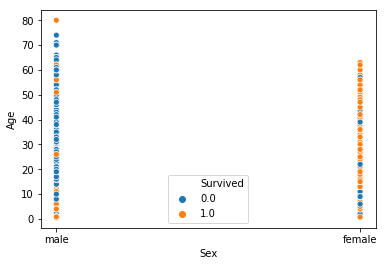

In [8]:
sns.scatterplot(x=data['Sex'],y=data['Age'],hue=data['Survived'])

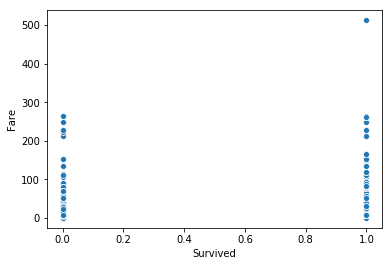

In [9]:
#票價和存活率較無關
sns.scatterplot(x=data['Survived'],y=data['Fare'])

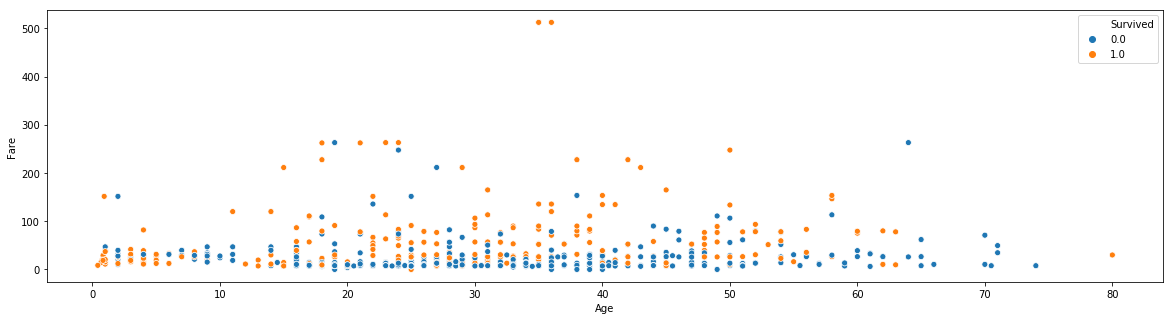

In [10]:
#觀察Fare和Age的關係
plt.figure(figsize=(20,5))
sns.scatterplot(x=data['Age'],y=data['Fare'],hue=data['Survived'])
#推論Fare對存活影響較大

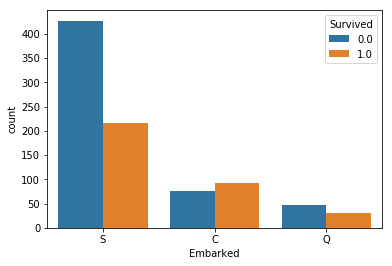

In [11]:
#embark 上船的地方 S港最多人死亡
sns.countplot(data['Embarked'],hue=data['Survived'])

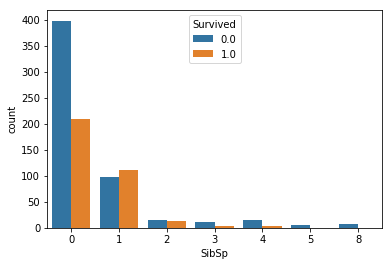

In [12]:
#觀察兄弟姊妹配偶數量和存活率的關係
sns.countplot(data['SibSp'],hue=data['Survived'])

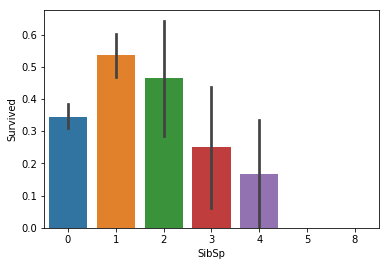

In [13]:
#有一個的時候存活率最高
sns.barplot(y=data['Survived'],x=data['SibSp'])

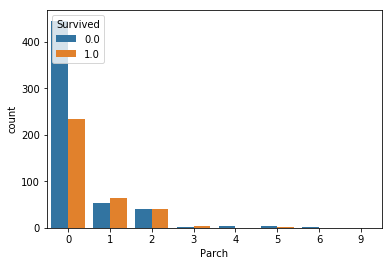

In [14]:
#觀察有小孩的數量和存活率的關係
sns.countplot(data['Parch'],hue=data['Survived'])

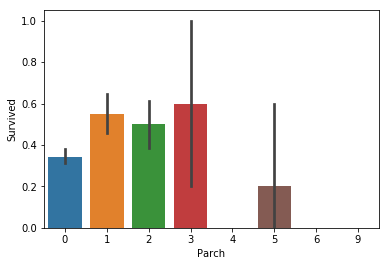

In [15]:
#沒有小孩的比較容易死
sns.barplot(y=data['Survived'],x=data['Parch'])

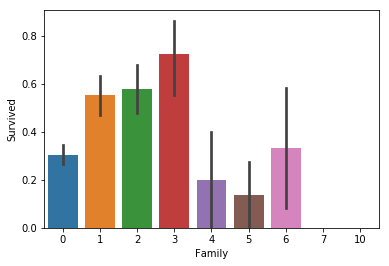

In [16]:
#由上述觀察可知 家人數量對於存活率是一樣的影響 越少越容易死亡 因此合併起來計算
data['Family']=data['Parch']+data['SibSp']
sns.barplot(y=data['Survived'],x=data['Family'])

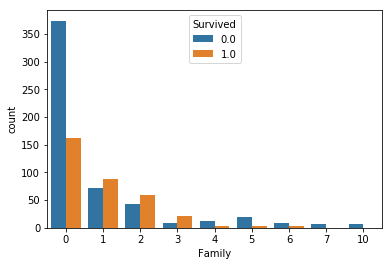

In [17]:
sns.countplot(data['Family'],hue=data['Survived'])

In [18]:
#資料前處理
#遺漏值處理
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Family         1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


In [19]:
#Embarked少一值用最多的S填補，Fare用平均值填補
data['Embarked']=data['Embarked'].fillna('S')
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

In [20]:
#cabin遺漏值最多 因此空值補NoCabin，並將資料一般化到第一個字母
data["Cabin"] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')
data["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

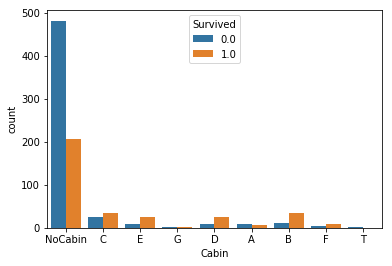

In [21]:
sns.countplot(data['Cabin'], hue=data['Survived'])

In [22]:
#特徵工程 一般化 正規化 類別資料轉換

In [23]:
#ticket 一般化到前面字母，可能代表位置，後面編號刪除
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [24]:
#Name一般化成 稱謂
data['Title1']=data['Name'].str.split(",",expand=True)[1]
data['Name'].str.split(",",expand=True).head(3)
data['Title1'].head(3)

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
Name: Title1, dtype: object

In [25]:
data['Title1']=data['Title1'].str.split(".",expand=True)[0]
data['Title1'].head(3)

0       Mr
1      Mrs
2     Miss
Name: Title1, dtype: object

In [26]:
data['Title1'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

Sex,female,male
Title1,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


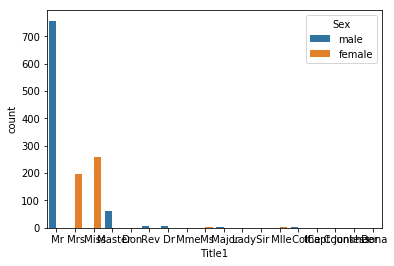

In [27]:
#分析稱謂和年齡的關係
sns.countplot(data['Title1'],hue=data['Sex'])
pd.crosstab(data['Title1'],data['Sex'])

In [28]:
data['Title2'] = data['Title1'].replace(regex={'Ms':'Miss',
                                               'Mme':'Mrs',
                                               'Mlle':'Miss',
                                               'Dona':'Mrs',
                                               'Dr':'Mr',
                                               'Major':'Mr',
                                               'Lady':'Mrs',
                                               'the Countess':'Mrs',
                                               'Jonkheer':'Mr',
                                               'Col':'Mr',
                                               'Rev':'Mr',
                                               'Capt':'Mr',
                                               'Sir':'Mr',
                                               'Don':'Mr'})

In [29]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master'], dtype=object)

In [30]:
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Title2'].unique()

array([2, 3, 1, 0], dtype=int64)

In [31]:
data[data['Age'].isnull()] 

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family,Ticket_info,Title1,Title2
5,NaN,NoCabin,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,0,X,Mr,2
17,NaN,NoCabin,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373,0,X,Mr,2
19,NaN,NoCabin,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649,0,X,Mrs,3
26,NaN,NoCabin,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,male,0,0.0,2631,0,X,Mr,2
28,NaN,NoCabin,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,female,0,1.0,330959,0,X,Miss,1
29,NaN,NoCabin,S,7.8958,"Todoroff, Mr. Lalio",0,30,3,male,0,0.0,349216,0,X,Mr,2
31,NaN,B,C,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,32,1,female,1,1.0,PC 17569,1,PC,Mrs,3
32,NaN,NoCabin,Q,7.7500,"Glynn, Miss. Mary Agatha",0,33,3,female,0,1.0,335677,0,X,Miss,1
36,NaN,NoCabin,C,7.2292,"Mamee, Mr. Hanna",0,37,3,male,0,1.0,2677,0,X,Mr,2
42,NaN,NoCabin,C,7.8958,"Kraeff, Mr. Theodor",0,43,3,male,0,0.0,349253,0,X,Mr,2


In [32]:
#年齡資料用稱謂平均值填補
data.groupby(['Title2'])['Age'].mean()

Title2
0     5.482642
1    21.824366
2    32.811056
3    36.971264
Name: Age, dtype: float64

In [33]:
data.groupby(['Title2'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Title2,,,,,,,,
0,53.0,5.482642,4.161554,0.33,2.0,4.0,9.0,14.5
1,213.0,21.824366,12.171431,0.17,15.0,22.0,30.0,63.0
2,606.0,32.811056,12.663745,11.00,23.0,30.0,40.0,80.0
3,174.0,36.971264,12.821779,14.00,27.0,35.5,46.5,76.0


In [34]:
for idx,row in data[data['Age'].isnull()].iterrows():
  
    if row['Title2']==0:
        data.loc[idx,'Age']=5.482642
    elif row['Title2']==1:
        data.loc[idx,'Age']=21.824366
    elif row['Title2']==2:
        data.loc[idx,'Age']=32.811056
    elif row['Title2']==3:
        data.loc[idx,'Age']=36.971264
data.info()
#準確率0.78947

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Family         1309 non-null int64
Ticket_info    1309 non-null object
Title1         1309 non-null object
Title2         1309 non-null int8
dtypes: float64(3), int64(5), int8(1), object(7)
memory usage: 154.8+ KB


In [35]:
#類別資料轉數值資料
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
#data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes

In [36]:
#data.drop(['Ticket','SibSp','Parch','Name','Title1'],axis=1,inplace=True)
#data.head()

In [37]:
#年齡的填補用隨機森林來預測值
#dataAgeNull = data[data["Age"].isnull()]
#dataAgeNotNull = data[data["Age"].notnull()]
#remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
#                      (np.abs(dataAgeNotNull["Family"]-dataAgeNotNull["Family"].mean())>(4*dataAgeNotNull["Family"].std()))                     
#                     ]
#rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
#ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title1', 'Title2','Cabin','Ticket_info']
#rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

#ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
#dataAgeNull.loc[:,"Age"] = ageNullValues
#data = dataAgeNull.append(dataAgeNotNull)
#data.reset_index(inplace=True, drop=True)

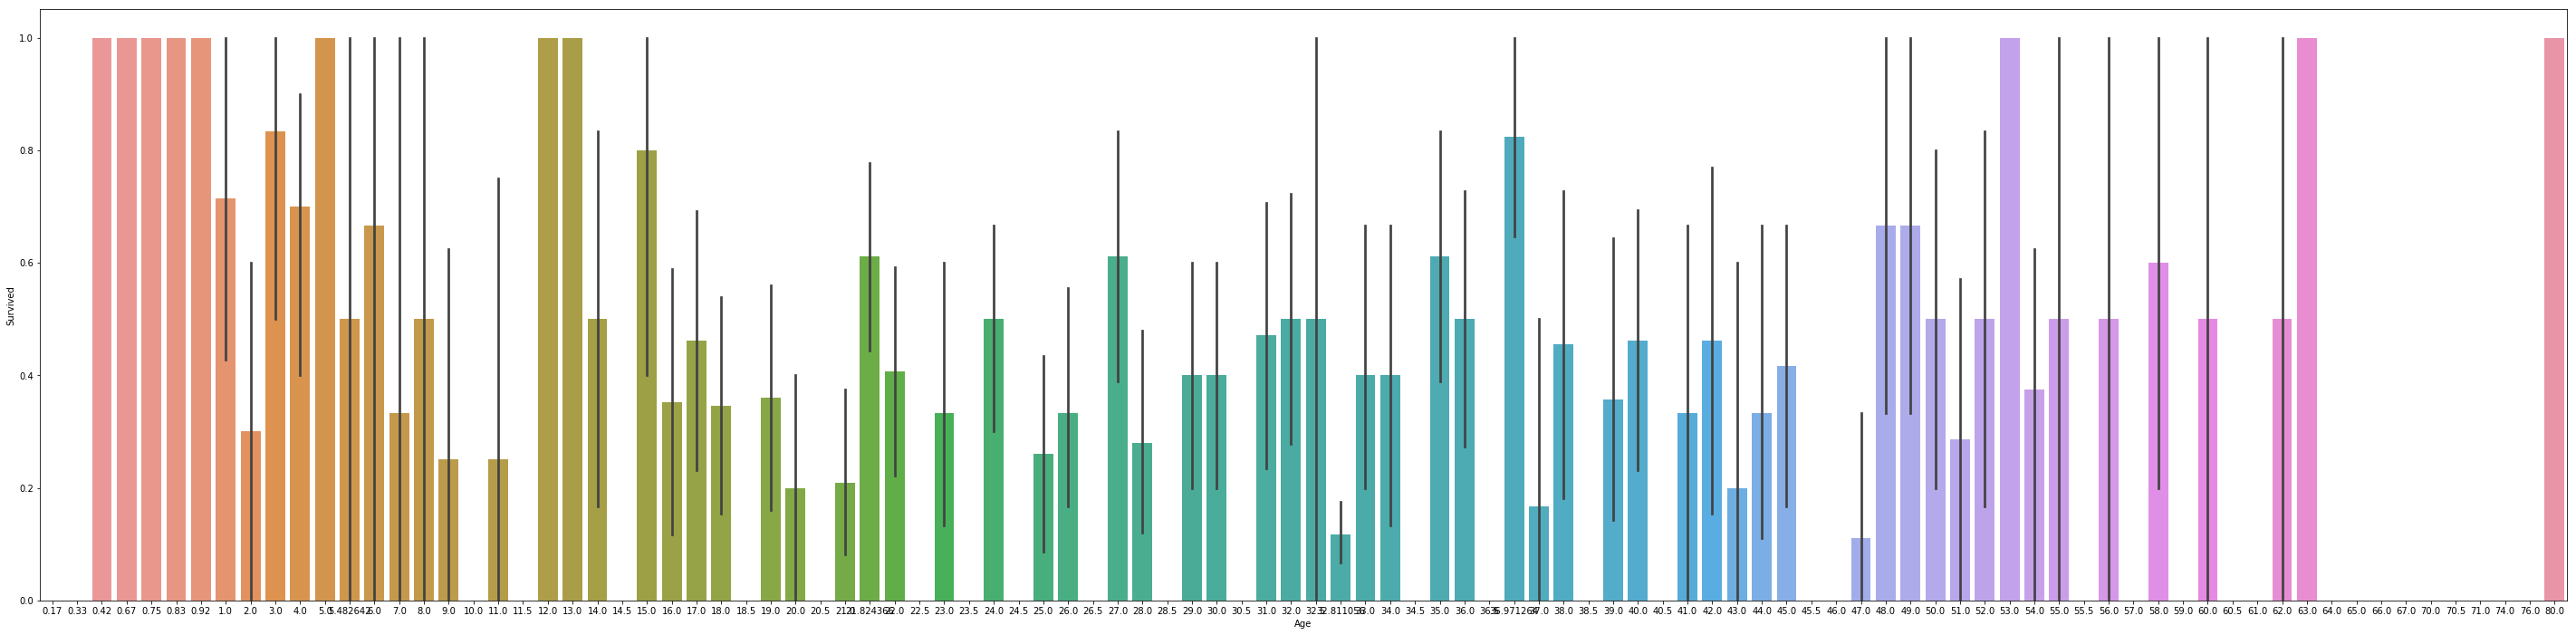

In [38]:
#比未預測補值前的圖還要亂 也許可以換換方式填值
plt.figure(figsize=(50,12))
sns.barplot(y=data['Survived'],x=data['Age'])

In [39]:
#進行隨機森林預測生存率
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family', 'Ticket_info',
       'Title1', 'Title2'],
      dtype='object')

In [40]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTrain

,Survived,Age,Embarked,Fare,Pclass,Sex,Family,Title2,Ticket_info,Cabin
0,0.0,22.000000,2,7.2500,2,1,1,2,2,7
1,1.0,38.000000,0,71.2833,0,0,1,3,14,2
2,1.0,26.000000,2,7.9250,2,0,0,1,31,7
3,1.0,35.000000,2,53.1000,0,0,1,3,36,2
4,0.0,35.000000,2,8.0500,2,1,0,2,36,7
5,0.0,32.811056,1,8.4583,2,1,0,2,36,7
6,0.0,54.000000,2,51.8625,0,1,0,2,36,4
7,0.0,2.000000,2,21.0750,2,1,4,0,36,7
8,1.0,27.000000,2,11.1333,2,0,2,3,36,7
9,1.0,14.000000,0,30.0708,1,0,1,3,36,7


In [41]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_) #交叉驗證

0.8305


In [42]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
4,Sex,0.264932
2,Fare,0.165450
6,Title2,0.151195
0,Age,0.130412
3,Pclass,0.089556
5,Family,0.071588
8,Cabin,0.068401
7,Ticket_info,0.032431
1,Embarked,0.026035


In [43]:
rf_res =  rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv', index= False)
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
